In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 

In [41]:
from sklearn.preprocessing import MinMaxScaler

df = pd.read_csv("..\data\ElectricityMap_DE_2021.csv", sep=",")
df = df[["datetime","power_production_wind_avg"]]

# seperate datetime into hour of day, day of year, and month of year
df["datetime"] = pd.to_datetime(df["datetime"])
df["hour_of_day"] = df["datetime"].dt.hour
df["day_of_year"] = df["datetime"].dt.day_of_year
df["month_of_year"] = df["datetime"].dt.month

# rescale data (min-max normalization)
df_norm = df.drop("datetime", axis=1)
df_norm = (df_norm-df_norm.min())/(df_norm.max()-df_norm.min())

# add sin time columns (range: 0-1)
df_sin = df_norm.drop("power_production_wind_avg", axis=1)
df_sin = df_sin.apply(lambda x: 0.5*np.sin(2*np.pi*x)+0.5)
df_sin = df_sin.add_prefix("sin_")

# merge columns
y = pd.concat([df_norm, df_sin], axis=1)

y.tail()


,power_production_wind_avg,hour_of_day,day_of_year,month_of_year,sin_hour_of_day,sin_day_of_year,sin_month_of_year
8755,0.784235,0.826087,1.0,1.0,0.056057,0.5,0.5
8756,0.726961,0.869565,1.0,1.0,0.134582,0.5,0.5
8757,0.703149,0.913043,1.0,1.0,0.240208,0.5,0.5
8758,0.680967,0.956522,1.0,1.0,0.365102,0.5,0.5
8759,0.666316,1.000000,1.0,1.0,0.500000,0.5,0.5


In [42]:
print(df.shape)

(8760, 5)


In [43]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i, step)
        data.append(dataset[indices])

        if single_step:
            labels.append(target[i+target_size])
        else:
            labels.append(target[i:i+target_size])

    return np.array(data), np.array(labels)

In [44]:
# choose input and output parameters
x_single = y[["power_production_wind_avg", "sin_hour_of_day",
              "sin_day_of_year", "sin_month_of_year"]].to_numpy()
y_single = y[["power_production_wind_avg"]].to_numpy()

# testplit as usual, so we get untouched data for later evaluation
testsplit = int(0.8 * y.shape[0])
print(testsplit)

# how many "x" inputs to provide in the RNN
past_history = 24*7

# how many "yhat" outputs to make/how many timesteps into the future to predict
future_target = 24

# this can be set to 1. If you have extremely large datasets where values
# don't change a lot during single time steps, this can be set to a higher
# value such that, e.g., only every 6th time step is used
step = 1

# prepare the data
# inputs here are y and y, since we're only going to predict a single feature (power production wind) at first
# "single_step" needs to be set to "True" if only the next timestep should be predicted
x_train_single, y_train_single = multivariate_data(x_single, y_single, 0, testsplit,
                                                   past_history, future_target, step,
                                                   single_step=False)
x_test_single, y_test_single = multivariate_data(x_single, y_single, testsplit, None,
                                                 past_history, future_target, step,
                                                 single_step=False)

# the network later expects arrays with 3 dimensions, so we have to reshape
# the x_... arrays to reflect that they contain a single feature

x_train_single = x_train_single.reshape(*x_train_single.shape, 1)
x_test_single = x_test_single.reshape(*x_test_single.shape, 1)

# print shapes
# print("shape of y:", y.shape)
# print("shapes of x_train and y_train: ",
#       x_train_single.shape, y_train_single.shape)
# print("shapes of x_test and y_test: ", x_test_single.shape, y_test_single.shape)

# print a few values
# print("")
# print(x_train_single[:3, :3])

# print()
# print("x_train[300]: ", *x_train_single[300][:3], "...")
# print("y_train[0] :  ", y_train_single[0][:3], "...")


7008


In [45]:
print(x_train_single.shape)

(6840, 168, 4, 1)


In [46]:
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras import backend as K
from tensorflow.keras.backend import clear_session
# clear_session() deletes stale model, so that when this cell is executed again,
# no older model reside in memory
clear_session()

# r2_score defined manually, since it's not implemented in keras
def r2_score(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true-y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

# below, create a sequential model like before called "single_feature_model"
# 
# then, add an LSTM layer (the class is already imported) with 128 hidden
# vector components. As a second argument you have to provide the
# "input_shape=", that has to be a tuple of the second and third dimension
# of x_train_single, like (20, 30). You can use x_train_single.shape for example to get them
# 
# lastly, add a "Dense" layer like in the lessons before, with as many neurons as
# there are future predictions. That number is saved in the variable "future_target".
# choose an appropriate activation function here. Which ones make sense?
single_feature_model = Sequential()
single_feature_model.add(LSTM(128, input_shape=x_train_single.shape[1:3]))
single_feature_model.add(Dense(future_target, activation='selu'))

# compile the model with the optimizer 'adam', an appropriate loss function, and 
# the "r2_score" defined above as a metric
single_feature_model.compile(optimizer="adam", loss="mse", metrics=r2_score)

# check what the model looks like
single_feature_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               68096     
                                                                 
 dense (Dense)               (None, 24)                3096      
                                                                 
Total params: 71,192
Trainable params: 71,192
Non-trainable params: 0
_________________________________________________________________


In [47]:
single_feature_history = single_feature_model.fit(x_train_single, y_train_single, epochs=5, validation_split=0.25)

Epoch 1/5
161/161 [==============================] - 20s 105ms/step - loss: 0.0263 - r2_score: 0.3803 - val_loss: 0.0191 - val_r2_score: -1.4623
Epoch 2/5
161/161 [==============================] - 16s 99ms/step - loss: 0.0198 - r2_score: 0.5301 - val_loss: 0.0185 - val_r2_score: -1.3653
Epoch 3/5
161/161 [==============================] - 22s 139ms/step - loss: 0.0184 - r2_score: 0.5703 - val_loss: 0.0176 - val_r2_score: -1.3043
Epoch 4/5
161/161 [==============================] - 36s 224ms/step - loss: 0.0178 - r2_score: 0.5763 - val_loss: 0.0171 - val_r2_score: -1.2297
Epoch 5/5
161/161 [==============================] - 33s 202ms/step - loss: 0.0175 - r2_score: 0.5810 - val_loss: 0.0167 - val_r2_score: -1.1704


dict_keys(['loss', 'r2_score', 'val_loss', 'val_r2_score'])


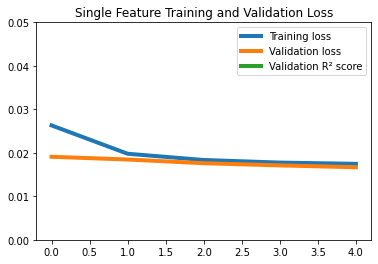

In [49]:
print(single_feature_history.history.keys())

def plot_train_history(history, title):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    val_r2_score = history.history['val_r2_score']

    epochs = range(len(loss))

    plt.figure()

    plt.plot(epochs, loss, lw=4, label='Training loss')
    plt.plot(epochs, val_loss, lw=4, label='Validation loss')
    plt.plot(epochs, val_r2_score, lw=4, label='Validation R² score')
    plt.title(title)
    plt.legend()
    plt.ylim([0,0.05])

    plt.show()
    
plot_train_history(single_feature_history, 'Single Feature Training and Validation Loss')

In [50]:
y_hat = single_feature_model.predict(x_test_single)

49/49 [==============================] - 2s 27ms/step


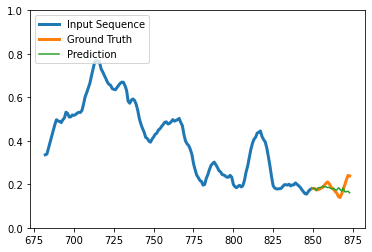

In [57]:
# prediction starting point.
predctStartPt = 850

t = np.arange(y.shape[0])

predctPt = predctStartPt-past_history


plt.figure()

plt.plot(t[predctPt:past_history+predctPt], x_test_single[predctPt,:,0], lw=3, label="Input Sequence")
plt.plot(t[past_history+predctPt:past_history+predctPt+future_target], y_test_single[predctPt], lw=3, label="Ground Truth")
plt.plot(t[past_history+predctPt:past_history+predctPt+future_target], y_hat[predctPt], label="Prediction")
plt.legend(loc='upper left')
#plt.xlim([850, 980])
plt.ylim([0,1])

plt.show()